# XG Boost

In [1]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import numpy as np


In [2]:
food = pd.read_excel("food.xlsx", sheet_name="food")

food['healthy'] = (
    (food['kilocalories'] < 250) &
    (food['sodium'] < 300) &
    (food['cholesterol'] < 50) 
).astype(int)

food['total_fat'] = food['saturated_fat'] + food['polysaturated_fat'] + food['monosaturated_fat'] # adding a total fat column

# ratios that represent important macronutrients 
food['protein_ratio'] = food['protein'] / (food['kilocalories'] + 1e-5)
food['sugar_ratio'] = food['sugar'] / (food['kilocalories'] + 1e-5)
food['fat_ratio'] = food['total_fat'] / (food['kilocalories'] + 1e-5)
food['fiber_ratio'] = food['fiber'] / (food['kilocalories'] + 1e-5)

# using macronutrient ratios
features = ['protein_ratio', 'sugar_ratio', 'fat_ratio', 'fiber_ratio']

In [3]:

X = food[features]
y = food['healthy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3540)

param = {
    'n_estimators': [25, 35, 50],
    'max_depth': [7, 9, 15, None],
    'learning_rate': [0.15, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Base model
model = XGBClassifier(
    eval_metric='logloss',
    random_state=3540
)

# Grid search with k-fold CV to find best parameters
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param,
    scoring='accuracy',
    cv=5,  # Using 5-fold CV for parameter tuning
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)
print(f"Best params: {grid_search.best_params_}")

# Best model
best_model = grid_search.best_estimator_



Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 35, 'subsample': 0.8}


In [4]:
# K-Fold Validation
cv_scores = cross_val_score(best_model, X_train, y_train, # not touching test data until I have to
                            cv=KFold(n_splits=5, shuffle=True, random_state=3540), scoring='accuracy').mean()

print(f"Cross-validation accuracy: {cv_scores:.4f}")

best_model.fit(X_train, y_train)  # Train on entire training set
y_pred = best_model.predict(X_test)

print(f"\nTest set accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Cross-validation accuracy: 0.8401

Test set accuracy: 0.8348
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1008
           1       0.76      0.71      0.73       475

    accuracy                           0.83      1483
   macro avg       0.81      0.80      0.81      1483
weighted avg       0.83      0.83      0.83      1483



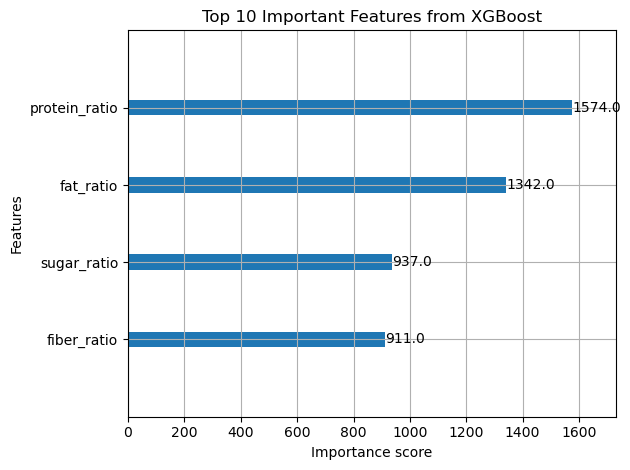

In [5]:
plot_importance(best_model, max_num_features=10)
plt.title("Top 10 Important Features from XGBoost")
plt.tight_layout()
plt.show()

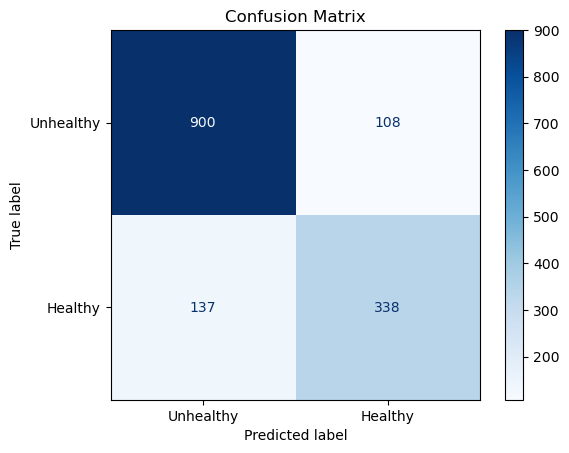

In [6]:


ConfusionMatrixDisplay.from_estimator(
    best_model, 
    X_test, 
    y_test,
    display_labels=['Unhealthy', 'Healthy'],
    cmap='Blues'
)
plt.title('Confusion Matrix')
plt.show()